
# Project Proposal — Heart Disease Prediction

## 1 - Introduction

Heart disease and its effective diagnosis is a global health challenge. In this proposal, we aim to address diagnosing heart diseases using machine learning techniques. We will attempt to detect the presence of heart disease in patients by leveraging a heart disease dataset obtained from Kaggle. 
###         Data Selection and Justification

While the original dataset from Kaggle comprises 16 variables, we have strategically chosen 6 variables based on their clinically established correlation with heart disease. By focusing on a subset of six variables, we aim to create a model that is both efficient and effective, avoiding the complexity and potential overfitting associated with using a larger number of variables.

1. **Patient ID (id)**: This identifier is used to track individual patient data.
2. **Age (age)**: Age is a well-known risk factor for heart disease. Older individuals have a higher risk, making this variable crucial for our model.
3. **Resting Blood Pressure (trestbps)**: High blood pressure is a known risk factor for heart disease. It can lead to hardening and thickening of the arteries, increasing heart disease risk.
4. **Serum Cholesterol (chol)**: High cholesterol levels can lead to atherosclerosis, increasing heart disease risk.
5. **Maximum Heart Rate (thalach)**: Lower maximum heart rate during exercise is associated with a higher risk of heart disease.
6. **Heart Disease (presence)**: This variable, indicating the degree of blockages in major vessels, is a direct measure of heart disease. In the initial dataset, the diagnosis (num) ranges from 0 (no presence) to 4. However, we have compressed it into two categories:

     - P (present): < 50% diameter narrowing, indicating significant heart disease.
     - A (absent): > 50% diameter narrowing, indicating no significant heart disease.
     
The decision to compress the "num" column (or presence in our study) into two classes (P and A) stems from the need for a clear, binary classification for our KNN classification model. This simplification also addresses potential issues with ambiguous labels in the dataset—allowing us to effectively train our model to distinguish only between two crucial states of heart diseases (present or absent). 

### Project Goal:

#### Can a K-nearest neighbors (KNN) classification effectively diagnose heart disease using age, resting blood pressure, cholesterol levels, and maximum heart rate as predictors?

##### This approach aims to provide a simplified yet accurate tool for early heart disease diagnosis, potentially aiding in prompt treatment and management.





## 2 - Preliminary Exploratory Data Analysis

 ### 2(a). Data Cleaning and Wrangling

In [1]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(shiny)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

#### Preparing the Heart Disease Dataframe

First, we will begin by downloading the original heart disease data from online.

In [40]:
url <- "https://raw.githubusercontent.com/MAmouzouvi/dsci-100-2022w1-group-10/main/data/heart_disease_uci.csv"

heart_disease_uci <- read_csv(url)
head(heart_disease_uci)

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,63,Male,Cleveland,typical angina,145,233,TRUE,lv hypertrophy,150,FALSE,2.3,downsloping,0,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160,286,FALSE,lv hypertrophy,108,TRUE,1.5,flat,3,normal,2
3,67,Male,Cleveland,asymptomatic,120,229,FALSE,lv hypertrophy,129,TRUE,2.6,flat,2,reversable defect,1
4,37,Male,Cleveland,non-anginal,130,250,FALSE,normal,187,FALSE,3.5,downsloping,0,normal,0
5,41,Female,Cleveland,atypical angina,130,204,FALSE,lv hypertrophy,172,FALSE,1.4,upsloping,0,normal,0
6,56,Male,Cleveland,atypical angina,120,236,FALSE,normal,178,FALSE,0.8,upsloping,0,normal,0


`Figure 2.1: Data frame showing the untransformed observations of the heart disease data set.`

#### Selection  
Now, we will reduce the data frame to include only our selected variables in order to get the most accurate results for our question.  

Moreover, we notice the variable `num` is the diagnosis of the heart disease, which is not a very clear label, so let's change it to `presence` which is a more descriptive label.

In [3]:
heart_disease_data <- heart_disease_uci |> 
         rename(presence = num) |>
         select(id, age, trestbps, chol, thalch, presence)
heart_disease_data

id,age,trestbps,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,63,145,233,150,0
2,67,160,286,108,2
3,67,120,229,129,1
⋮,⋮,⋮,⋮,⋮,⋮
918,55,122,223,100,2
919,58,NA,385,NA,0
920,62,120,254,93,1


`Figure 2.2: Data frame showing the transformed observations of the heart disease data set including selected variables (id, age, trestbps, chol, thalch, presence).`

#### Categorical Variable and Data Wrangling

Since we will be working with `presence` as a categorical variable, let's convert it to a factor type. 

Let's also compress the `presence` variable into two classes (`P` for present and `A` for absent) to allow for a clearer binary classification for our KNN classification model. This is to address potential issues with ambiguous labels in the dataset— allowing us to effectively train our model to distinguish only between two crucial states of heart diseases (present or absent).

Finally, we remove rows with `NA` values

In [4]:
# mutate presence to a factor
heart_disease_data <- heart_disease_data |>
            mutate(presence = ifelse(presence == 0, "P", "A")) |> 
            mutate(presence = as_factor(presence))

# Taking out the NA value in the dataset
heart_disease_data <- na.omit(heart_disease_data)
heart_disease_data

id,age,trestbps,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,145,233,150,P
2,67,160,286,108,A
3,67,120,229,129,A
⋮,⋮,⋮,⋮,⋮,⋮
916,54,127,333,154,A
918,55,122,223,100,A
920,62,120,254,93,A


`Figure 2.3: Summary table of heart disease data reflecting the new classes for presence (A and P) as well as the removal of missing values`

#### Now we will split our data into training and testing sets.

In [42]:
set.seed(3456)

heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = presence)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

 ### 2(b). Summary Tables 

In [43]:
set.seed(3456)

num_of_observations <- nrow(heart_disease_train)

# Table that reports the percentage of observations in presence (N vs P)
percentage_per_P_and_A <- heart_disease_train |>
  group_by(presence) |>
  summarize(
    count = n(),
    percentage = n() / num_of_observations * 100
  )
percentage_per_P_and_A

presence,count,percentage
<fct>,<int>,<dbl>
P,279,44.71154
A,345,55.28846


`Figure 2.4: A table that summarizes the number of P (present) and A (absent) diagnoses from the observations with missing values removed.`

From the above table, we observed that the percentages for both P (45%) and A (55%) are almost similar, thus we decided to continue with our sample without extra measures to balance them equally since there is not a drastic difference. 

#### Evaluating the Means of Predictors

In [74]:
set.seed(3456)

mean_of_predictors <- heart_disease_train |>
  group_by(presence) |>
  summarize(across(age:thalch, ~ mean(.)))

mean_of_predictors

presence,age,trestbps,chol,thalch
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
P,50.31183,129.0072,227.8889,150.1147
A,55.53333,134.4290,172.3507,128.1130


`Figure 2.5: A table showing the means of each predictor variable selected for each diagnosis of heart disease`

From this table we can observe that there is a great difference in the means of `chol` and `thalch` between the presence and absence of heart disease. This could imply that they are good predictors, however, we will be doing further analysis on scaled data to test this assumption, as the unscaled data is not enough.

## 3 - Visualization

### 3(a). Scaling the Dataframe

In [75]:
set.seed(3456)
heart_disease_recipe  <- recipe(presence ~ age + trestbps + chol + thalch, data = heart_disease_train) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors()) |>
                       prep()

heart_disease_train_scaled <- bake(heart_disease_recipe, heart_disease_train)

heart_disease_train_scaled 

age,trestbps,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.4838148,-0.6205049,0.2808761,-0.3474694,A
0.9462507,0.4132558,0.6251594,0.8560128,A
1.0537635,-0.1036246,0.5015705,0.3513267,A
⋮,⋮,⋮,⋮,⋮
0.4086866,-0.1036246,0.0866650,-1.6285956,P
1.5913277,0.1031276,0.5015705,0.5066147,P
-0.2363904,-0.9306331,0.5368816,-1.6285956,P


`Figure 3.1: Table summarizing the scaled data of the heart disease data set.`

#### Graphs

In [21]:
install.packages("GGally")
library(GGally)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


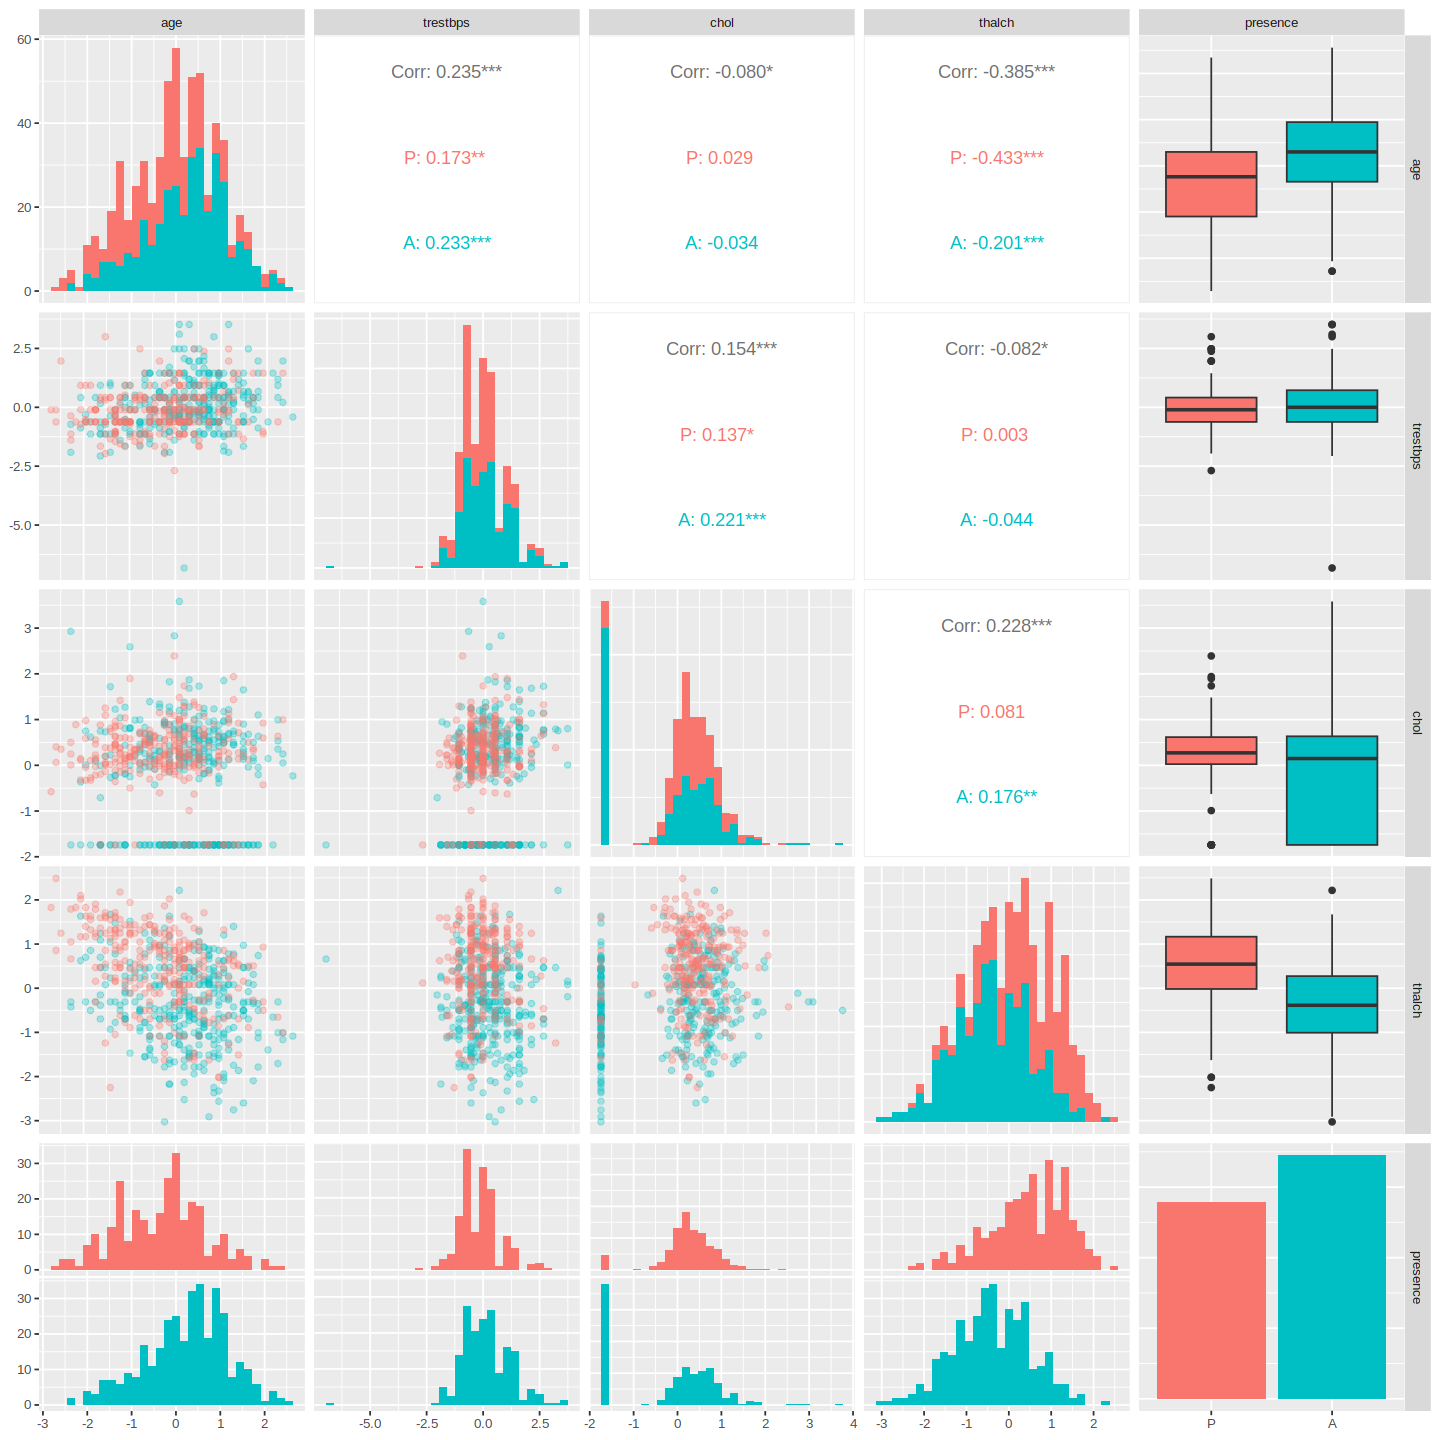

In [23]:
set.seed(3456)
# Getting the GGpair Plot to compare the trend between each variable 
options(repr.plot.width = 12, repr.plot.height = 12)
credit_pairplot <- heart_disease_train_scaled |> 
    ggpairs(
        mapping = aes(color = presence),
        lower = list(continuous = wrap('points', alpha = 0.3)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 10))

credit_pairplot

`Figure 3.2: Multiple graphs showing the distributions of each of the chosen predictors tested against one another. The right-most column of graphs reveal box-plots which test each predictor against the presence (red) or absence (blue) of heart disease`. 

#### GGpair Graph Observation

Based on the above graphs, we focused on the right-most column to determine which predictors are most relevant for our study as they compare each variable to `presence`. We observe that the `trestbps` (Resting Blood Pressure) percentile boxes are very similar in their ranges and means. Thus, this reveals that the variable does not significantly contribute to help differentiate between each diagnosis, A (absent) and P (present), for heart disease. Therefore, we will eliminate the `trestbps` predictor to get better prediction results to our study. 

### 3(b). Updating our data and recipes

In [65]:
heart_disease_train_updated <- select(heart_disease_train, -trestbps)
heart_disease_train_updated

heart_disease_test_updated <- select(heart_disease_test, -trestbps)

id,age,chol,thalch,presence
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,67,229,129,A
7,62,268,160,A
9,63,254,147,A
⋮,⋮,⋮,⋮,⋮
905,57,207,96,P
910,68,254,151,P
911,51,258,96,P


`Figure 3.3: A glimpse of the data frame after the removal of the trestbps predictor. The data now only includes the variables id, age, chol, thalc and presence.`

## 4. Data Searching/Modeling


In [66]:
install.packages("kknn")
library(kknn)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
33,accuracy,binary,0.7403484,5,0.01916092,Preprocessor1_Model05
9,accuracy,binary,0.7371613,5,0.01491504,Preprocessor1_Model02
41,accuracy,binary,0.7355742,5,0.01409189,Preprocessor1_Model06
⋮,⋮,⋮,⋮,⋮,⋮,⋮
121,accuracy,binary,0.7131742,5,0.009009566,Preprocessor1_Model16
137,accuracy,binary,0.7115613,5,0.008937717,Preprocessor1_Model18
1,accuracy,binary,0.6489548,5,0.014077508,Preprocessor1_Model01


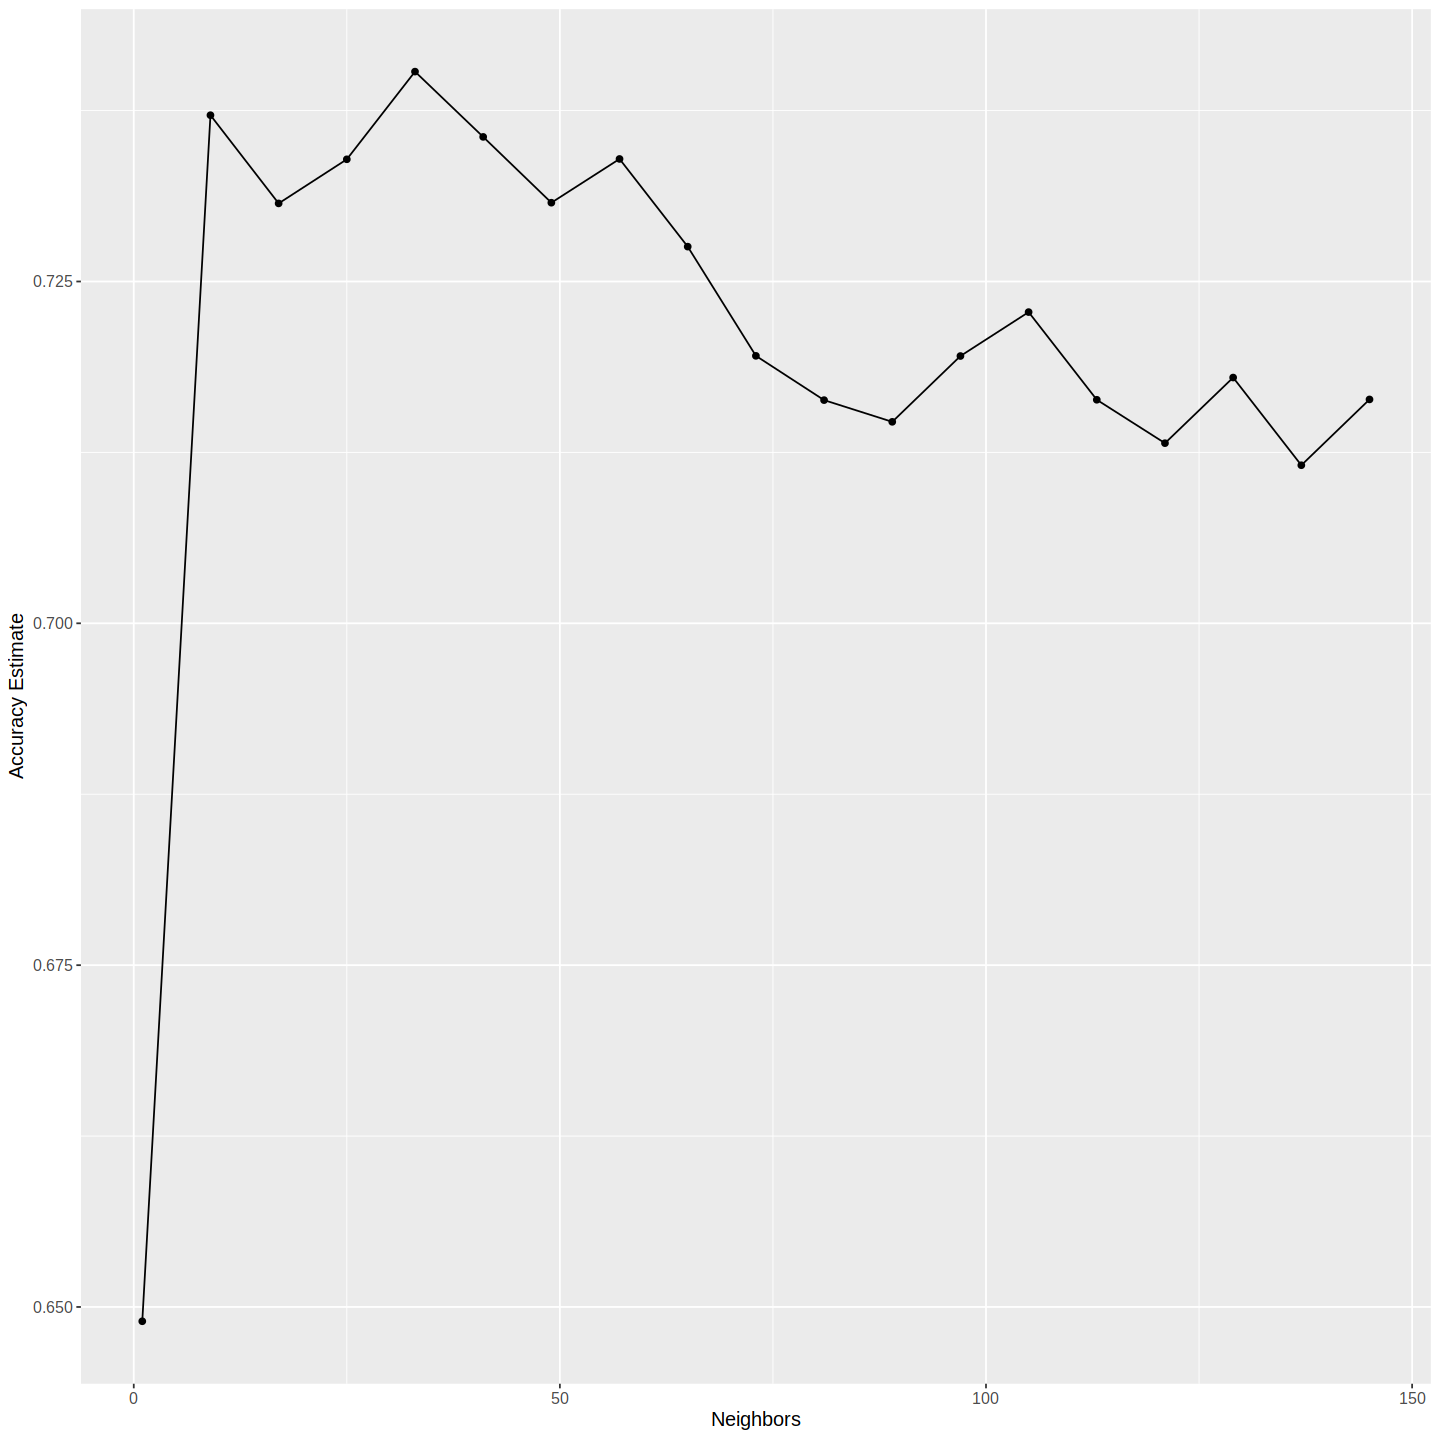

In [76]:
set.seed(3456)
# validation set testing 

# Create the spec for heart disease following the classification method
heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification") 

k_vfold <- vfold_cv(heart_disease_train_updated, v = 5, strata = presence)


k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 8))

new_heart_disease_recipe  <- recipe(presence ~ age + chol + thalch, data = heart_disease_train_updated) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors())

knn_fit <- workflow() |>
    add_recipe(new_heart_disease_recipe) |>
    add_model(heart_disease_spec) |>
    tune_grid(resamples = k_vfold, grid = k_vals) |>
    collect_metrics() 




accuracies <- knn_fit |>
    filter(.metric == "accuracy")


accuracies |>
    arrange(desc(mean))


cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

# This code print out the graph for showing K-nearest Neighbor Mean Distribution
cross_val_plot

`Figure 4.1: Graph of K-values against their accuracy estimates to the model.`

##### K-nearest neighbors graph observation
Looking at the above graph, the maximum value of the plot (the highest point) reveals to us which value of K which will provide us with the greatest accuracy estimate for our model. Thus, we will select this value, K = 33, and next train our classifier tool with it. 

#### Training Classifier with K = 33

In [77]:
set.seed(3456)

heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 33) |>
    set_engine("kknn") |>
    set_mode("classification") 


heart_disease_fit_k33 <- workflow() |>
    add_recipe(new_heart_disease_recipe) |>
    add_model(heart_disease_spec) |>
    fit(data = heart_disease_train_updated)

heart_disease_fit_k33

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(33,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2532051
Best kernel: rectangular
Best k: 33

#### Predicting the labels

In [80]:
# heart_disease_fit 
heart_disease_test_predictions <- predict(heart_disease_fit_k33, heart_disease_test_updated) |>
      bind_cols(heart_disease_test_updated)

heart_disease_test_predictions

.pred_class,id,age,chol,thalch,presence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
A,2,67,286,108,A
P,10,53,203,155,A
A,13,56,256,142,A
⋮,⋮,⋮,⋮,⋮,⋮
A,898,64,258,130,A
A,918,55,223,100,A
A,920,62,254,93,A


`Figure 4.2: A table showing a summary of the predictions of heart disease presence using our age, chol and thalch as predictors`

From the glimpse of the data provided, we can already see a single instance of our model incorrectly predicting heart disease. Although all other instances were correctly estimated, this indicates our model may not entirely accurate. Thus, we will test for the true performance of our model in the following steps.

#### Evaluating performance

In [71]:
heart_disease_test_predictions |>
  metrics(truth = presence, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6952381


`Figure 4.3: Data revealing the accuracy of estimation of our model`

According to the Figure 4.3, our model did a moderate job of predicting the diagnosis of heart disease from our selected predictors with an accuracy of about 70%. We will further evaluate the performance of our model below using a confusion matrix and then calculating the values.

In [84]:
confusion <- heart_disease_test_predictions |>
             conf_mat(truth = presence, estimate = .pred_class)
confusion

          Truth
Prediction  P  A
         P 61 31
         A 33 85

`Figure 4.4: Confusion matrix showing the number of correct and incorrect predictions of our estimates.`

In [85]:
accuracy <- (61 + 85)/(61 + 31 + 33 + 85)
accuracy

precision <- (61)/(61 + 31)
precision

recall <- (61)/(61 + 33)
recall

[1] 0.6952381

[1] 0.6630435

[1] 0.6489362

##### Let's break down each metric:

Accuracy (0.695):
Accuracy is a measure of the overall correctness of the model. It is the ratio of correctly predicted instances to the total instances. In this case, our model has an accuracy of 69.5%. This means that the model correctly predicted the class of the samples around 69.5% of the time.

Precision (0.663):
Precision is the ratio of correctly predicted positive observations to the total predicted positives. In other words, it measures how many of the predicted positive instances are actually positive. A precision of 66.3% suggests that when the model predicts a positive class, it is correct about 66.3% of the time.

Recall (0.649):
Recall, also known as sensitivity or true positive rate, is the ratio of correctly predicted positive observations to all the actual positives. It measures how well the model captures all the positive instances. A recall of 64.9% indicates that the model correctly identified 64.9% of the actual positive instances.

Our prediction results are adequate numbers to indicate the success of our prediction and meaning that the results may help us answer our original question. 

## 5 - Discussion

Our group expect to find whether K-nearest neighbors classification is an effective method for diagnosing heart disease based on our predictors. We also expect to evaluate the model's performance in terms of accuracy, sensitivity, and recall ratios.

The Impacts of the Project Findings:
If KNN proves to be effective, it could contribute to a quicker and more effective diagnosis of heart disease and help professionals make more informed treatment options. This can significantly reduce healthcare expenses—decreasing unnecessary procedures. 

Future Questions:
- Are our proposals considered variables the most informative for heart disease diagnosis, or are there other key features that should be considered?
- How does knn performance compare to other machine learning algorithms or traditional diagnostic methods in diagnosing heart disease?




## 6 - References